# The GF2 & GW method

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import sparse_ir
import sys 
import math

In [2]:
T = 0.1
wmax = 1

beta = 1/T

In [3]:
#construction of the Kernel K

# Fermionic Basis

basisf = sparse_ir.FiniteTempBasis('F', beta, wmax)

matsf = sparse_ir.MatsubaraSampling(basisf)
tausf = sparse_ir.TauSampling(basisf)

# Bosonic Basis

basisb = sparse_ir.FiniteTempBasis('B', beta, wmax)
      
matsb = sparse_ir.MatsubaraSampling(basisb)
tausb = sparse_ir.TauSampling(basisb)

# Note:
# * The distribution of sampling times is symmetric around beta/2. 
# * By default, the same sampling times are used for the fermioc and bosonic cases.

In [4]:
def rho(x):
    return 2/np.pi*np.sqrt(1-(x/wmax)**2)

rho_l = basisf.v.overlap(rho)

G_l_0 = -basisf.s*rho_l  


# We compute G_iw two times as we will need G_iw_0 as a constant later on
G_iw_0 = matsf.evaluate(G_l_0)
G_iw_f = matsf.evaluate(G_l_0)

In [5]:
# Iterations
i = 0

# storage for E_iw to show convergence after iterations
E_iw_f_arr = []

Above we have successfully derived $G^F(\bar{\tau}_k^F)$ from $\hat {G}^F(i\bar{\omega}_n^F)$ by first obtaining the Green's function's basis representation $G_l^F$ and secondly evaluating $G_l^F$ on the $\tau$-sampling points, which are given by the computations of sparse_ir. Here, the self-consistent second order Green's function theory (GF2) and the self-consistent GW methodare are based this very mechanism (and the so called Hedin equations).[5][7]

The following image should give an overview on their iterative schemes[5]:

<br>

![GF2_GW_pic.PNG](GF2_GW_pic.PNG)

Evaluation and transformation in GW and GF2 is done in the same way (fitting and evaluating) for the quantities $G,P,W$ and $\Sigma$. The transition between these quantities is given by the Hedin equations. There are five Hedin equations in total. Because the vertex function (between $P$ and $W$) is approximated as $\Gamma=1$, we will only deal with four of them here.[9]

Let us start with computing $G_l^F$ from the imaginary-frequency Green's function we have obtained above. This will also be the starting point for every new iteration one might want to perform.

In [6]:
# Calculation of G_l_f using Least-Squares Fitting
G_l_f = matsf.fit(G_iw_f)

                
# G_tau,fermionic   
G_tau_f = tausf.evaluate(G_l_f)

The next step in order to perform a full iteration of GF2 & GW is the evaluation of the basis representation $G_l^F$ on the $\tau$-sampling points.  Contrary to before when we computed $G(\bar{\tau}_k^F)$, these sampling point will be the bosonic sampling points $\tau_k^B$. This allows us to switch to bosonic statistic and thus be able to calculate associated quantities like the Polarization $P$.[5]

$$G(\bar{\tau}_k^B)= \sum_{l=0}^{L-1}G_l^F  U_l^F(\bar{\tau}_k^B)$$

In [7]:
# G_tau, bosonic
G_tau_b = tausb.evaluate(G_l_f)

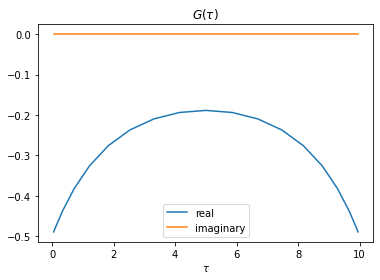

In [8]:
pl.plot(tausb.tau,G_tau_b.real,label='real')
pl.plot(tausb.tau,G_tau_b.imag,label='imaginary')

pl.title(r'$G(\tau)$')
pl.xlabel(r'$\tau$')
pl.legend()
pl.show()

## $P(\bar\tau_k^B)$

The so-called Polarization $P(\bar\tau_k^B)$ is given by the random phase approximation, a connection between two Green's functions:

$$P(\bar{\tau}_k^B)=G(\bar{\tau}_k^B)*G(\beta-\bar{\tau}_k^B)$$

In [9]:
# Polarisation P, bosonic
# Note: The distribution of sampling times is symmetric around beta/2.
P_tau_b = G_tau_b * G_tau_b[::-1]

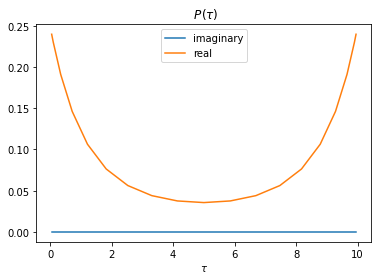

In [10]:
pl.plot(tausb.tau,P_tau_b.imag,label='imaginary')
pl.plot(tausb.tau,P_tau_b.real,label='real')

pl.title(r' $P(\tau)$')
pl.xlabel(r'$\tau$')
pl.legend()
pl.show()

The same way we transformed $\hat G^F(i\bar{\omega}_n^F)$ into $G^B(\bar\tau_k^B)$ we are now able to transform $P^B(\bar\tau_k^B)$ into $\hat P^B(i\bar{\omega}_n^B)$ again using least Square fitting and evaluating $P_l^B$ on the given sampling points (Matsubara frequencies).

## $P_l^B$

In [11]:
# P_l, bosonic
P_l_b = tausb.fit(P_tau_b)

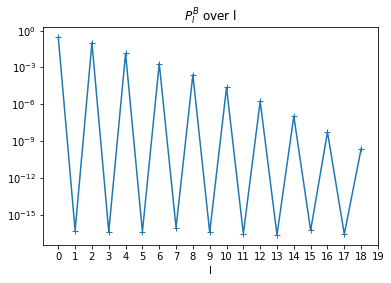

In [12]:
pl.semilogy(np.abs(P_l_b),'+-')
pl.title('$P_l^B$ over l ')
pl.xticks(range(0,20))
pl.xlabel('l')
pl.show()

$$\hat{P}(i\bar{\omega}_k^B)= \sum_{l=0}^{N-1} P_l^B\hat{U}_l^B(i\bar{\omega}_n^B)$$

In [13]:
#P_iw, bosonic
P_iw_b = matsb.evaluate(P_l_b)

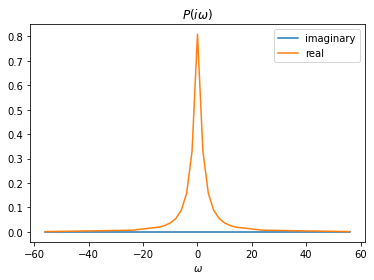

In [14]:
pl.plot(matsb.wn,P_iw_b.imag,label='imaginary')
pl.plot(matsb.wn,P_iw_b.real,label='real')
pl.title(r'$P(i\omega)$')
pl.xlabel(r'$\omega$')
pl.legend()
pl.show()

## $\hat{{W}}(i\bar{\omega}_n^B)$

Following $P$ we will now calculate the Screened Interaction $W$ with the following formula: 
 
$$\hat{{W}}(i\bar{\omega}_n^B)= U + U\hat{P}(i\bar{\omega}_n^B)\hat{{W}}(i\bar{\omega}_n^B)$$

or

$$\hat{{W}}(i\bar{\omega}_n^B)= \frac{U}{1-U\hat{P}(i\bar{\omega}_n^B)}$$

This equation has the exact same form as the Dyson equation but instead of connecting the Green's functions and the self energy it connects the Screened Coulomb Interaction $W$ and the polarization operator $P$. Because $U$ is the bare Coulomb interaction and $P$ is an object containing all irreducible processes (meaning in Feynmann diagrams cutting an interaction line U does not result in two sides) $W$ can be understood as the sum of all possible Feymann diagrams with an interaction U between its two parts.[5][11] This becomes quite intuitive if we look at 

$$W= U + UPW= U+UP(U+UP(U+UP(...)))=U+UPU+...$$

In [15]:
# W_iw, bosonic  
U = 1/2

W_iw_b_U = U/(1-(U*P_iw_b))

W_iw_b = W_iw_b_U-U

#W_iw_b is the part depending on the frequency, any further calculations 
#will be done using this and not W_iw_b_U

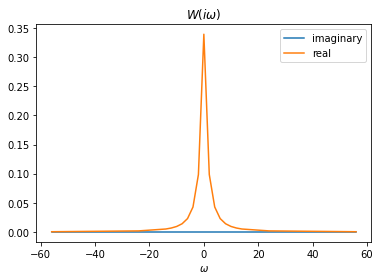

In [16]:
pl.plot(matsb.wn,W_iw_b.imag,label='imaginary')
pl.plot(matsb.wn,W_iw_b.real,label='real')
pl.title(r'$W(i\omega)$')
pl.xlabel(r'$\omega$')
pl.legend()
pl.show()

## $W_l^B$

In [17]:
# W_l, bosonic
W_l_b = matsb.fit(W_iw_b)

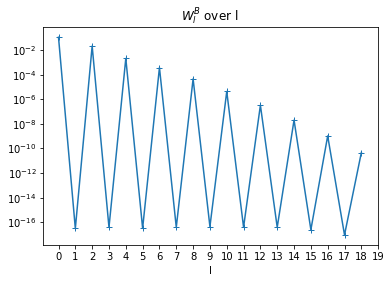

In [18]:
pl.semilogy(np.abs(W_l_b),'+-')
pl.title('$W_l^B$ over l ')
pl.xticks(range(0,20))
pl.xlabel('l')
pl.show()

## ${W}(\bar{\tau}_k^F)$

In the next step we are changing back into fermionic statistics: 

$${W}(\bar{\tau}_k^F)= \sum_{l=0}^{N-1} W_l ^BU_l^B(\bar{\tau}_k^F) $$

In [19]:
# W_tau_f, fermionic
W_tau_f = tausf.evaluate(W_l_b)

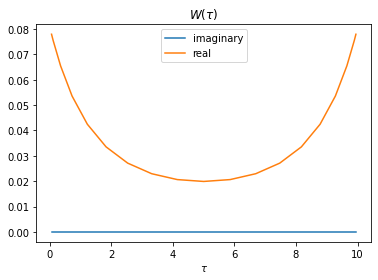

In [20]:
pl.plot(tausf.tau,W_tau_f.imag,label='imaginary')
pl.plot(tausf.tau,W_tau_f.real,label='real')
pl.title(r'$W(\tau)$')
pl.xlabel(r'$\tau$')
pl.legend()
pl.show()

## ${\Sigma}(\bar{\tau}_k^F)$

After changing back into fermionic statistics the next quantity that is being dealt with is the so-called self energy $\Sigma$. When we first introduced the Dyson equation in the first chapter, we saw $V$ as some sort of pertubation. The self-energy is very much alike as it describes the correlation effects of a many-body system. Here we will calculate $\tilde{\Sigma}(\bar{\tau}_k^F)$ using $\Sigma^{GW}$ so that

$${\Sigma}(\bar{\tau}_k^F)=-G(\bar{\tau}_k^F)*{W}(\bar{\tau}_k^F).$$

This can again be rewritten into its equivalent form

$$\Sigma=-G(U+UP(U+UP(...)))= -(GU+GUPU+GUPUPU+...)$$

In [21]:
# E_tau , fermionic   
E_tau_f = G_tau_f * W_tau_f

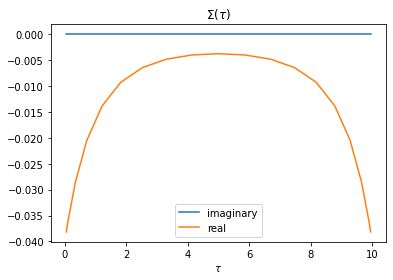

In [22]:
pl.plot(tausf.tau, E_tau_f.imag, label='imaginary')
pl.plot(tausf.tau, E_tau_f.real, label='real')
pl.title(r'$\Sigma(\tau)$')
pl.xlabel(r'$\tau$')
pl.legend()
pl.show()

## ${\Sigma}_l^F$

In [23]:
# E_l, fermionic
E_l_f = tausf.fit(E_tau_f)

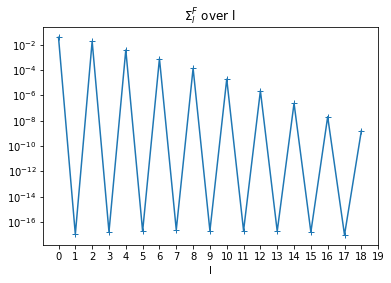

In [24]:
pl.semilogy(np.abs(E_l_f),'+-')
pl.title('$\Sigma_l^F$ over l ')
pl.xticks(range(0,20))
pl.xlabel('l')
pl.show()

We will calculate

$$\hat{\Sigma}(i\bar{\omega}_n^F)=-UG(\beta)+\sum_{l=0}^{N-1}{\Sigma}_l^F \hat{U}_l^F(i\bar{\omega}_n^F)$$

with $UG(\beta)$ as the so called Hartee Fock term.

In [25]:
# E_iw, fermionic
E_iw_f_U = matsf.evaluate(E_l_f)-U*(basisf.u(beta).T@G_l_f)
E_iw_f = matsf.evaluate(E_l_f)


#store E_iw_f of this iteration in E_iw_f_arr
E_iw_f_arr.append(E_iw_f_U)

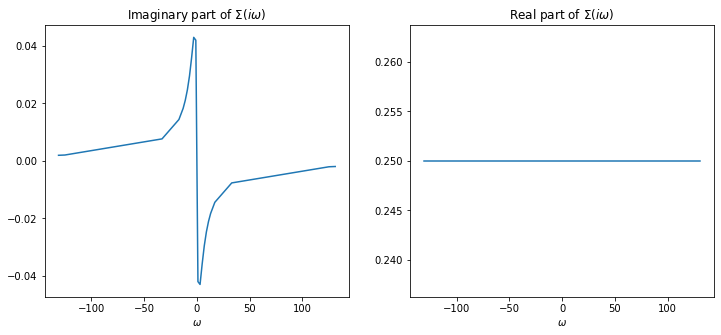

In [26]:
fig, ax = pl.subplots(1,2, figsize=(12,5) )
ax[0].plot(matsf.wn,E_iw_f_U.imag)
ax[0].set_title('Imaginary part of $\Sigma(i\omega)$')
ax[0].set_xlabel(r'$\omega$')
ax[1].plot(matsf.wn,E_iw_f_U.real)
ax[1].set_title('Real part of $\Sigma(i\omega)$')
ax[1].set_xlabel(r'$\omega$')
pl.show()

Last but not least we will obtain $G^F(i\bar{\omega}_n^F)$ through the Dyson Equation of GW:

$$\hat{G}(i\bar{\omega}_k^F)=G_0(i\bar{\omega}_k^F)+G_0(i\bar{\omega}_k^F)\hat{\Sigma}(i\bar{\omega}_n^F)\hat{G}(i\bar{\omega}_k^F)$$

or

$$\hat{G}(i\bar{\omega}_k^F)=\frac{1}{G_0(i\bar{\omega}_k^F)^{-1}-\hat{\Sigma}(i\bar{\omega}_n^F)}$$

We have now calculated the full Green's function of the system with $\Sigma$ as a set of (one-particle) irreducible processes connected by $G_0$.[11]

In [27]:
#G_iw, fermonic     -> Dyson Equation

G_iw_f = ((G_iw_0)**-1-E_iw_f)**-1    

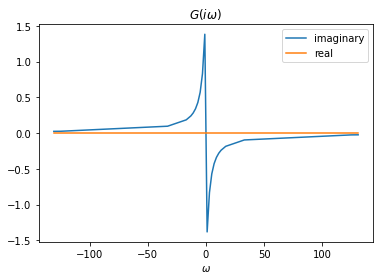

In [28]:
pl.plot(matsf.wn, G_iw_f.imag, label='imaginary')
pl.plot(matsf.wn, G_iw_f.real, label='real')
pl.title(r'$G(i\omega)$')
pl.xlabel(r'$\omega$')
pl.legend()
pl.show()

In [29]:
if (i > 0):
    pl.plot(matsf.wn, E_iw_f_arr[i].imag, label='current')
    pl.title(r'$\Sigma(i\omega)$ in the current and previous iteration')
    pl.plot(matsf.wn, E_iw_f_arr[i-1].imag, '.', label='previous')
    pl.legend()
    pl.show()
    pl.plot(matsf.wn, np.abs(E_iw_f_arr[i]-E_iw_f_arr[i-1]))
    pl.title(r'$|\Sigma_i(i\omega)-\Sigma_{i-1}(i\omega)|$' )
    

In [30]:
#Iterations 
i += 1
print('full iterations: ',i)

full iterations:  1


In [31]:
print(G_iw_f)

[ 2.96089515e-19+0.02429373j -1.64652734e-18+0.02545934j
 -2.14193523e-18+0.09616324j -9.42895770e-18+0.18513256j
  5.69249615e-18+0.24022776j -6.17006733e-18+0.28186922j
  1.47640761e-17+0.34036864j -5.30050111e-18+0.4278915j
 -2.68390310e-19+0.57065346j -1.19655494e-17+0.83239627j
  7.81184795e-17+1.38269615j  1.14038194e-16-1.38269615j
  1.98642344e-18-0.83239627j  9.83289823e-18-0.57065346j
 -2.12165336e-18-0.4278915j   1.66611769e-17-0.34036864j
 -6.39227115e-18-0.28186922j  6.04497764e-18-0.24022776j
 -8.87414921e-18-0.18513256j -2.12905029e-18-0.09616324j
 -1.61097987e-18-0.02545934j  3.27325259e-19-0.02429373j]


With this we have completed one full iteration of GF2 & GW. Repeating this over and over again will show convergence and thus give the desired approximation to the self-energy.

Sources
---------

[1] H.Bruus, Karsten Flensberg,_Many-body Quantum Theory in Condensed    Matter  Physics_ (Oxford University Press Inc., New York, 2004)<br>
[2] J.W.Negele, H.Orland, _Quantum Many-Particle Systems_ (Westview Press, 1998)<br>
[3] G.D.Mahan,_Many-Particle Physics_ (Kluwer Academic/Plenum Publishers, New York, 2000)<br>
[4] P.C.Hansen,_Dicrete Inverse Problems_(Society for Industrial and Applied Mathematics, Philadelphia,2010)<br>
[5] J.Li, M.Wallerberger, N.Chikano, C.Yeh, E.Gull and H.Shinaoka, Sparse sampling approach to efficient ab initio calculations at finite temperature, Phys. Rev. B 101, 035144 (2020)<br>
[6] M.Wallerberger, H. Shinaoka, A.Kauch, Solving the Bethe–Salpeter equation with exponential convergence, Phys. Rev. Research 3, 033168 (2021)<br>
[7] H. Shinaoka, N. Chikano, E. Gull, J. Li, T. Nomoto, J. Otsuki, M. Wallerberger, T. Wang, K. Yoshimi, Efficient ab initio many-body calculations based on sparse modeling of Matsubara Green’s function (2021)<br>
[8] F. Aryasetiawan and O. Gunnarsson, The GW method, Rep. Prog. Phys. 61 (1998) 237<br>
[9] Matteo Gatti, _The GW approximation_, TDDFT school, Benasque (2014)<br>
[10]C.Friedrich, _Many-Body Pertubation Theory;The GW approximation_, Peter Grünberg Institut and Institute for Advanced Simulation, Jülich <br>
[11] K. Held, C. Taranto, G. Rohringer, and A. Toschi, _Hedin Equations, GW, GW+DMFT, and All That_ (Modeling and Simulation Vol. 1, Forschungszentrum Jülich, 2011 )